In [1]:
from tqdm.notebook import tqdm as tqm
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
from math import pi
import wave 

from scipy import fft
import pyfftw as fftw
# Opciones de matplotlib
rc=plt.rcParams
rc['figure.figsize']=[15,5]

# Para mostrar todas las columnas cuando se imprime un df
pd.set_option('display.max_columns', None)

Vemos una señal como se emite desde la fuente o percibida por un sólo micrófono

In [2]:
div=100
n_ventana=1024
freq_sampleo=48_000

T=n_ventana/freq_sampleo
t=np.linspace(0,T,num=div)
s1=np.sin(2*np.pi/T*t)

fig=px.line(x=t,y=s1,markers=True)

fig.update_layout(
    title='s1',xaxis_title='t', yaxis_title='s(t)',
    height=500, width=900, template='plotly_dark'
)

fig.show()


Las frecuencias que tiene la transformada de Fourier dividen el espacio que hay entre la frecuencia de NS al 0 entre la mitad de las muestras en el espacio temporal. También se refleja la frecuencia para incluir términos negativos. 

In [3]:
# Armamos el arreglo de frecuencias

def arreglo_frecuencias(freq_sampleo,n_ventana):
    
    f_NS=freq_sampleo//2
    freq_array=np.zeros(n_ventana)
    f1=freq_sampleo/n_ventana
    for i in range(1,len(freq_array)//2):
        freq_array[i]=f1*i 
        freq_array[len(freq_array)-i]=-freq_array[i]
    freq_array[n_ventana//2]=f_NS
    return freq_array

freq_array=arreglo_frecuencias(freq_sampleo,n_ventana=100)

In [4]:
s_hat=np.abs(fft.fft(s1))
freq_array_string=[str(fi) for fi in freq_array]
fig=px.bar(x=freq_array_string,y=s_hat)

fig.update_layout(
    title=f'Transformada de Fourier de señal sinusoidal con frecuencia {freq_array[1]}',xaxis_title='f:frecuencia', yaxis_title='|s_hat(f)|',
    height=500, width=900, template='plotly_dark'
)

fig.show()

# Recreando el archivo de music

Creamos señales y su salida a los respectivos micrófonos de acuerdo a los parámetros del archivo de music en octave

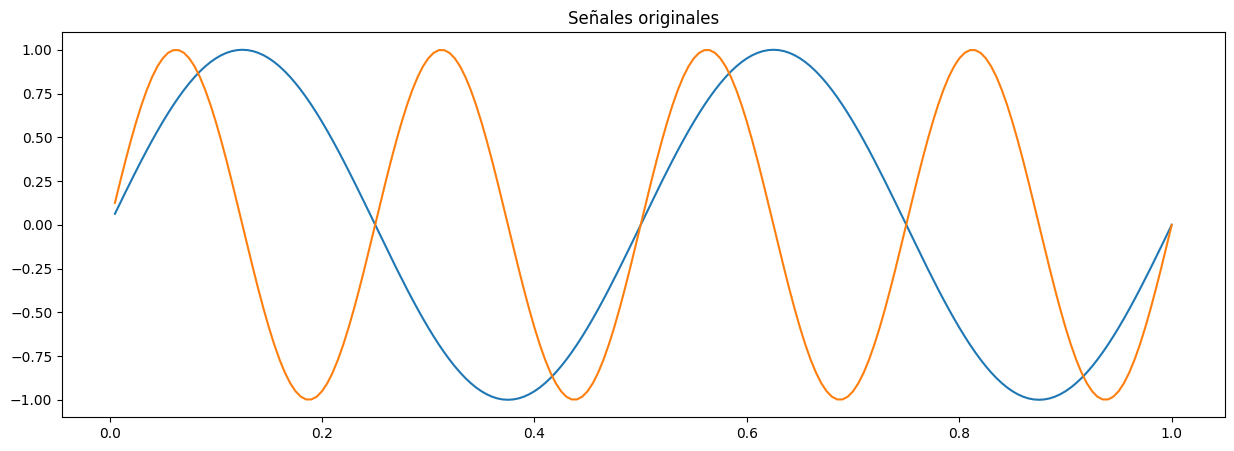

In [5]:
DOAS=[-30,40] # DOA en grados
d_im=20 # distancia inter-micrófono, arreglo lineal
K=200 # Tamaño de señal en sampleo, también es la frecuencia de sampleo
n_ventana=K
freq_sampleo=K

freq_array=arreglo_frecuencias(freq_sampleo,n_ventana)
freq_array_string=[str(fi) for fi in freq_array]

freqs=[2,4] # frecuencia de las señales
c=343 # Velocidad del sonido
t=np.linspace(1,K,num=K)/K

N_mic=3
n_ruidoso=2 

s1=np.sin(2*np.pi*freqs[0]*t)
s2=np.sin(2*np.pi*freqs[1]*t)

plt.title('Señales originales')
plt.plot(t,s1,label='Señal 1')
plt.plot(t,s2,label='Señal 2')
plt.show()

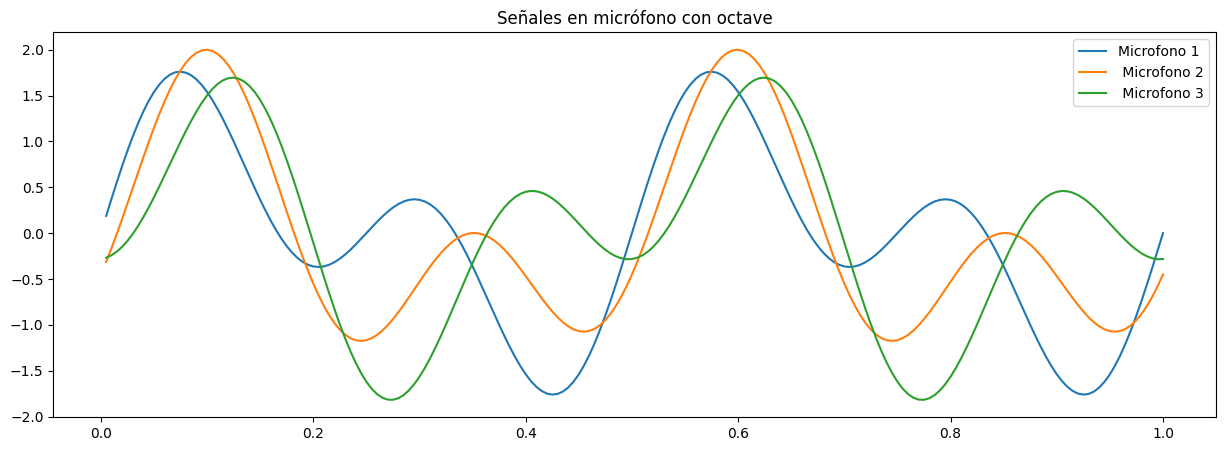

In [6]:
k=np.array([-2*pi*d_im/c*np.sin(di*pi/180) for di in DOAS]) # el exponente de cada exp por el que hay que multiplicar la transformada con la frecuencia para que dé el tensor S
# np.exp(-2*pi*1j)

x=s1+s2
y=fft.ifft(fft.fft(s1)*np.exp(k[0]*freq_array*1j)).real+fft.ifft(fft.fft(s2)*np.exp(k[1]*freq_array*1j)).real
z=fft.ifft(fft.fft(s1)*np.exp(2*k[0]*freq_array*1j)).real+fft.ifft(fft.fft(s2)*np.exp(k[1]*2*freq_array*1j)).real
plt.title('Señales en micrófono con octave')
plt.plot(t,x,label='Microfono 1')
plt.plot(t,y,label=' Microfono 2')
plt.plot(t,z,label=' Microfono 3')
plt.legend()
plt.show()

## Usando matrices
Hacemos el mismo cálculo usando la construcción de tensores que se utiliza en **MUSIC** y para comprobar lo checamos contra la gráfica anterior

In [7]:
def a_theta_f(theta,f,N_mic=N_mic,d_im=d_im,c=c):
    
    k=-2*pi*d_im/c*np.sin(theta*pi/180)
    a=[np.exp(k*f*ni*1j) for ni in range(N_mic)]
    return np.array(a)

def A_f(thetas,f,N_mic=N_mic,d_im=d_im,c=c):
    A=np.zeros(shape=(N_mic,len(thetas)))+0j
    for i in range(len(thetas)):
        A[:,i]=a_theta_f(thetas[i],f,d_im=d_im)
    
    return A


def A_completa(thetas,freqs,N_mic=N_mic,d_im=d_im,c=c):
    A=np.zeros(shape=(len(freqs),N_mic,len(thetas)))+0j
    for i in range(len(freqs)):
        A[i,:,:]=A_f(thetas,freqs[i],d_im=d_im)
    
    return A


In [8]:

# Comprobación con datos de señales entrantes
s_t=[s1,s2]
s_vec=s_t[0]
for i in range(1,len(s_t)):
    s_vec=np.c_[s_vec,s_t[i]]
# s_vec=np.c_[s_t]
s_vec=np.c_[s1,s2]


In [9]:
A=A_completa(DOAS,freqs=freq_array)
s_vec=np.c_[s1,s2]
s_hat_vec=fft.fft(s_vec,axis=0)
x_mics=np.zeros((N_mic,len(freq_array)))+0j
for i in range(A.shape[0]):
    x_mics[:,i]=A[i,:,:]@s_hat_vec[i,:]
x_mics=fft.ifft(x_mics,axis=1).real

In [10]:
s_vec.shape

(200, 2)

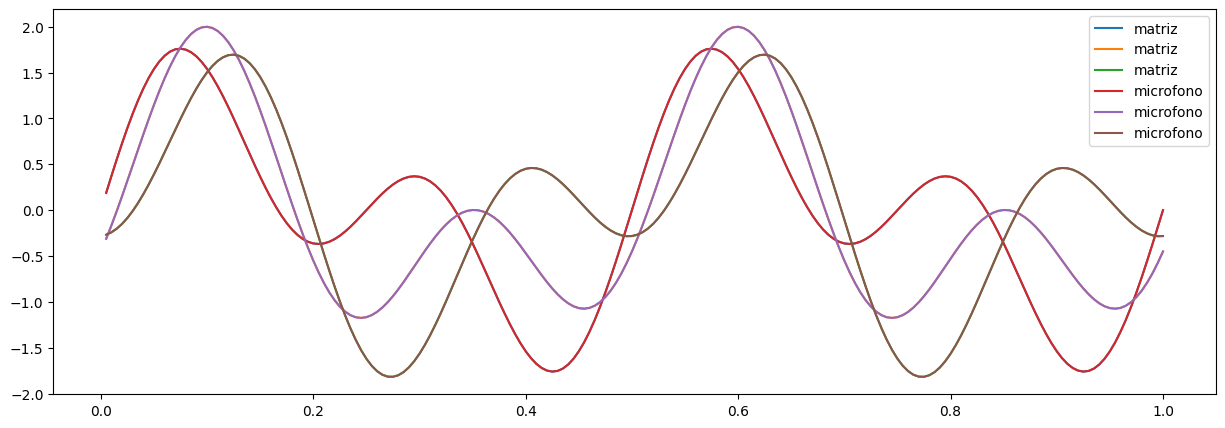

In [11]:
plt.plot(t,x_mics[0],label='matriz')
plt.plot(t,x_mics[1],label='matriz')
plt.plot(t,x_mics[2],label='matriz')

plt.plot(t,x,label='microfono')
plt.plot(t,y,label='microfono')
plt.plot(t,z,label='microfono')
plt.legend()
plt.show()

como sólo se ven tres gráficas confirmamos que se obtiene lo mismo

### Juntamos todo en una función

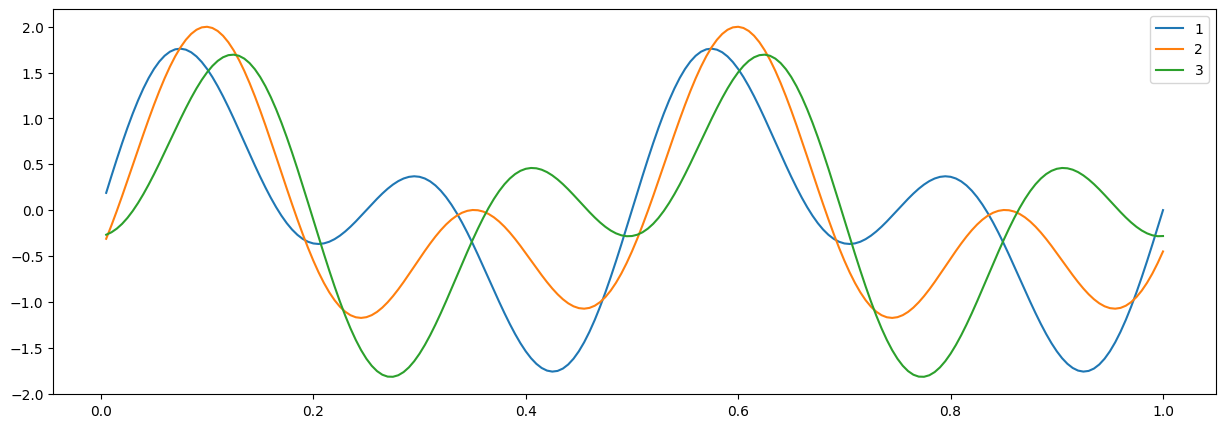

In [12]:
def gen_señales_mic(DOAS,señales,d_im,N_mic,n_ventana=1024,freq_sampleo=48_000):
    '''
    DOAS: Los ángulos en grados de las señales de entrada 
    d_im: distancia inter-micrófono
    n_ventana: el tamaño de la muestra 
    señales: funciones o arreglos que se le aplican a los datos 

    regresa las señales reales en cada micrófono
    '''
    
    # Se obtienen las frecuencias de la transformada rápida
    freq_array=arreglo_frecuencias(freq_sampleo,n_ventana)
  
    # freq_array_string=[str(fi) for fi in freq_array]
    t=np.linspace(1,n_ventana,num=n_ventana)*(n_ventana/freq_sampleo)/n_ventana # Para que esté en un intervalo de un segundo 
    s_t=[s(t) for s in señales]
    # return s_t

    A=A_completa(DOAS,freqs=freq_array,d_im=d_im)

    s_vec=s_t[0]
    for i in range(1,len(s_t)):
        s_vec=np.c_[s_vec,s_t[i]]

    s_hat_vec=fft.fft(s_vec,axis=0)

    x_mics=np.zeros((N_mic,len(freq_array)))+0j
    for i in range(A.shape[0]):
        x_mics[:,i]=A[i,:,:]@s_hat_vec[i,:]
    x_mics=fft.ifft(x_mics,axis=1).real
    return t,x_mics

señales=[lambda x: np.sin(2*pi*freqs[0]*x),lambda x: np.sin(2*pi*freqs[1]*x)]

x_mics=gen_señales_mic(DOAS,señales,d_im,N_mic,K,K)[1]
plt.plot(t,x_mics[0],label='1')
plt.plot(t,x_mics[1],label='2')
plt.plot(t,x_mics[2],label='3')

# plt.plot(t,x)
# plt.plot(t,y)
# plt.plot(t,z)
plt.legend()
plt.show()

# MUSIC Ejemplo de clase

Ya con las señales de micrófono en general, se puede
- Generar señales más complicadas que tengan más frecuencias
- Poner los parámetros del problema de JACK
- Dividir en ventanas para hacer wola y ver cómo se le va a hacer al problema en general

Pero antes de eso primero hay que tratar esto como si fuera una sóla ventana e ir haciendo el análisis de los estimadores de la función de covarianza

## Detectar DOAS en señal completa como si fuera una ventana usando music


Se tendría que buscar para todas las frecuencias, pero aquí ya sabemos que están en [2,4] 

In [13]:
fig=px.bar(x=freq_array_string,y=np.abs(s_hat_vec)[:,0])
fig.update_layout(
    title='Transformada para Señal 1',xaxis_title='f', yaxis_title='s1_hat(f)',
    height=500, width=900, template='plotly_dark',
)

fig.add_bar(x=freq_array_string,y=np.abs(s_hat_vec)[:,1],name='señal 2')
fig.show()



In [14]:
def MUSIC(this_ws,x_mics,angles,n_ruidoso):
    X=fft.fft(x_mics,axis=1)
    music_spectrum=np.zeros(shape=(len(this_ws),len(angles)))
    for i,wi in enumerate(this_ws):
        this_X=X[:,wi] # Esta es la que tiene que ser calculada usando ventanas anteriores. Cuando dividas en varias ventanas de Hann, se debería de ver una diferencia en la estimación
        R=this_X.reshape(-1,1)*this_X.conj().T

        D,Q=np.linalg.eig(R)
        I=np.argsort(D.real)[::-1]
        D=D[I]
        Q=Q[:,I]


        Qs=Q[:,1:n_ruidoso]
        Qn=Q[:,n_ruidoso:]

        A_angles=A_completa(thetas=angles,freqs=[wi])

        for k in range(len(angles)):
            music_spectrum[i,k]=np.abs(1/(A_angles[0,:,k].conj().T@(Qn*Qn.conj().T@A_angles[0,:,k])))
    return music_spectrum


In [15]:

# Se seleccionan las componentes de las señales en el espacio de frecuencia que buscamos 
this_ws=[2,4,6,8]

angles=np.arange(-90,90,0.1) # Los ángulos para buscar ortogonalidad

music_spectrum=MUSIC(this_ws,x_mics,angles,n_ruidoso)


In [16]:
def music_plot(angles,music_spectrum,this_ws,titulo='Music con ventana completa'):
    
    traces=[go.Scatter(x=angles,y=music_spectrum[i,:],mode='lines',name=f'Frecuencia {i}') for i in range(len(this_ws))]
    fig=go.Figure()
    [fig.add_trace(trace) for trace in traces]
    fig.update_layout(
        title=f'{titulo}',xaxis_title='x', yaxis_title='F(x)',
        height=500, width=900, template='plotly_dark'
    )
    fig.show()
    return

music_plot(angles,music_spectrum,this_ws)


Sólo las direcciones de arribo correctas se calculan bien

## Detectar DOAS usando HANN con señal completa

no se tiene que usar WOLA porque no lo vas a transformar de regreso

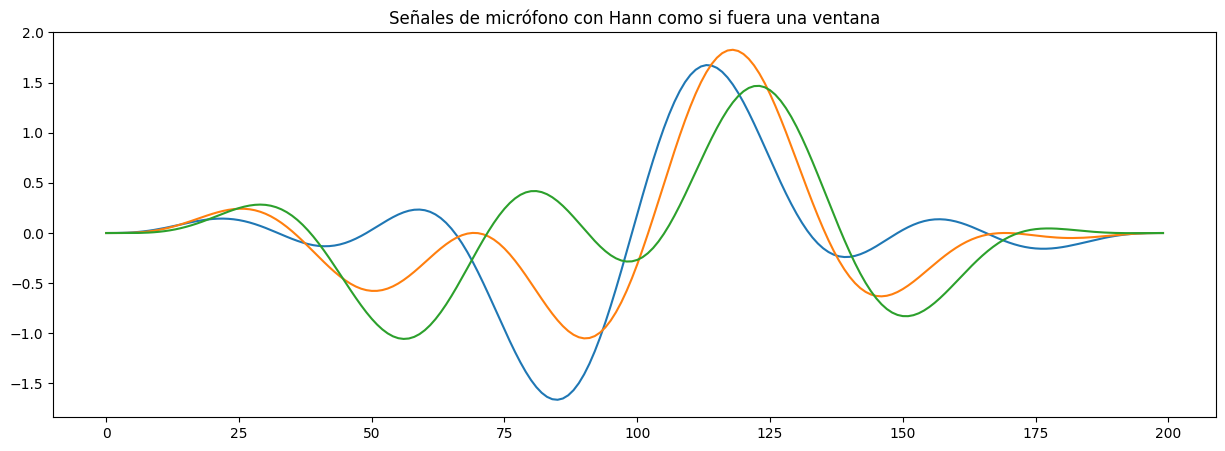

In [17]:

hann=0.5*(1-np.cos(2*pi*np.linspace(0,1,200)))
x_hann=x_mics*hann

plt.title('Señales de micrófono con Hann como si fuera una ventana')
plt.plot((x_hann)[0])
plt.plot((x_hann)[1])
plt.plot((x_hann)[2])
plt.show()

In [18]:
music_spectrum_hann=MUSIC(this_ws,x_hann,angles,n_ruidoso)
music_plot(angles,music_spectrum_hann,this_ws)

La diferencia es menos clara que cuando no se hace el Hann. Si se acerca a los picos se puede ver que tienen un ancho que no estaba en el procedimiento sin Hann.

## Detectar DOAS partiendo cada intervalo como si fuera una ventana 

Partimos nuestra señal de un segundo en ventanas de 1024 sampleadas con una frecuencia de 48000 Hz

In [19]:
t_ventanas,x_ventanas=gen_señales_mic(DOAS,señales,d_im,N_mic,n_ventana=48_000,freq_sampleo=48_000)
x_ventanas.shape

(3, 48000)

In [20]:
# Dividimos en ventanas de 1024
n_ventana=1024
freq_sampleo=48_000

t_v_array,x_v_array=[],[]

num_ventanas=freq_sampleo//n_ventana
for i in range(num_ventanas):
    t_v_array.append(t_ventanas[i*n_ventana:(i+1)*n_ventana])
    x_v_array.append(x_ventanas[:,i*n_ventana:(i+1)*n_ventana])

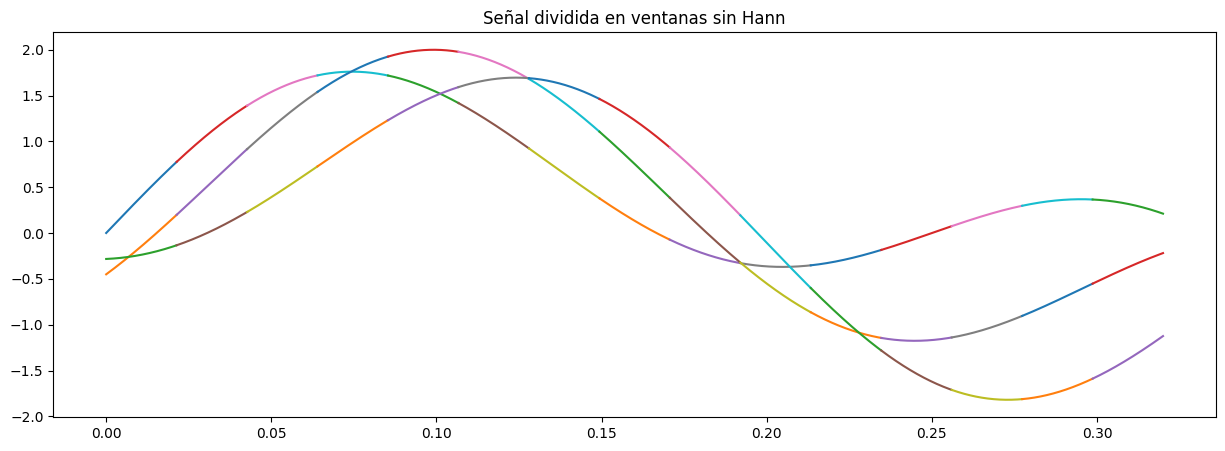

In [21]:
plt.title('Señal dividida en ventanas sin Hann')
for i in range(num_ventanas//3):
    plt.plot(t_v_array[i],x_v_array[i][0])
    plt.plot(t_v_array[i],x_v_array[i][1])
    plt.plot(t_v_array[i],x_v_array[i][2])

usando music en cada uno de los segmentos se obtiene

In [22]:
angs_max=[]
intens_max=[]
for ventana in range(num_ventanas):
    ms_ventana=MUSIC(this_ws,x_v_array[ventana],angles,n_ruidoso)
    idx_max=ms_ventana.argmax(axis=1)
    
    angs_max.append(angles[idx_max])
    intens_max.append(np.array([ms_ventana[i,idx_max[i]] for i in range(len(idx_max))]))

Distribución de los 4 ángulos máximos totales

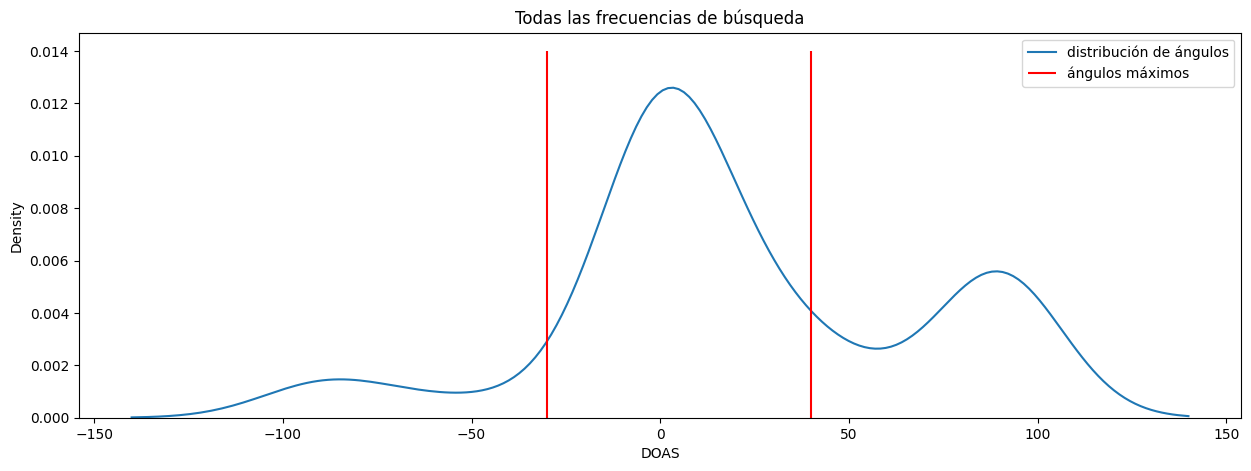

In [23]:
angulos_maximos=np.array(angs_max).reshape(-1)
plt.title('Todas las frecuencias de búsqueda')
sns.kdeplot(angulos_maximos,label='distribución de ángulos')
plt.vlines(x=DOAS,ymin=0,ymax=0.014,colors='r',label='ángulos máximos')
plt.xlabel('DOAS')
plt.legend()

Distribución de los top 2 ángulos

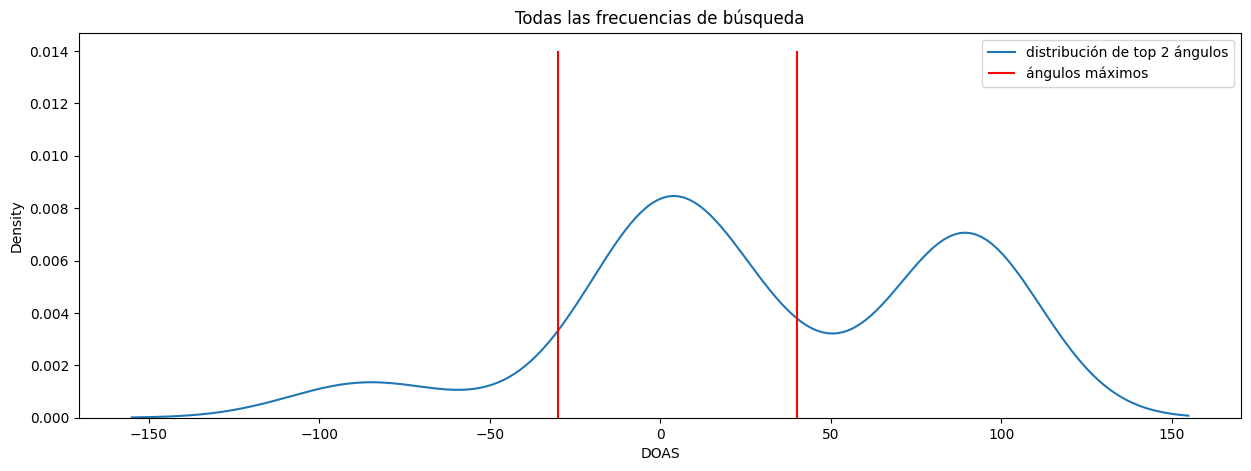

In [24]:
top_2_angs=[]
for a,i in zip(angs_max,intens_max):
    idx_int=np.argsort(i)
    top_2_angs.append(a[idx_int][:2])

angulos_maximos_2=np.array(top_2_angs).reshape(-1)
plt.title('Todas las frecuencias de búsqueda')
sns.kdeplot(angulos_maximos_2,label='distribución de top 2 ángulos')
plt.vlines(x=DOAS,ymin=0,ymax=0.014,colors='r',label='ángulos máximos')
plt.xlabel('DOAS')
plt.legend()

Vemos que ninguno de los dos métodos arroja algo bueno

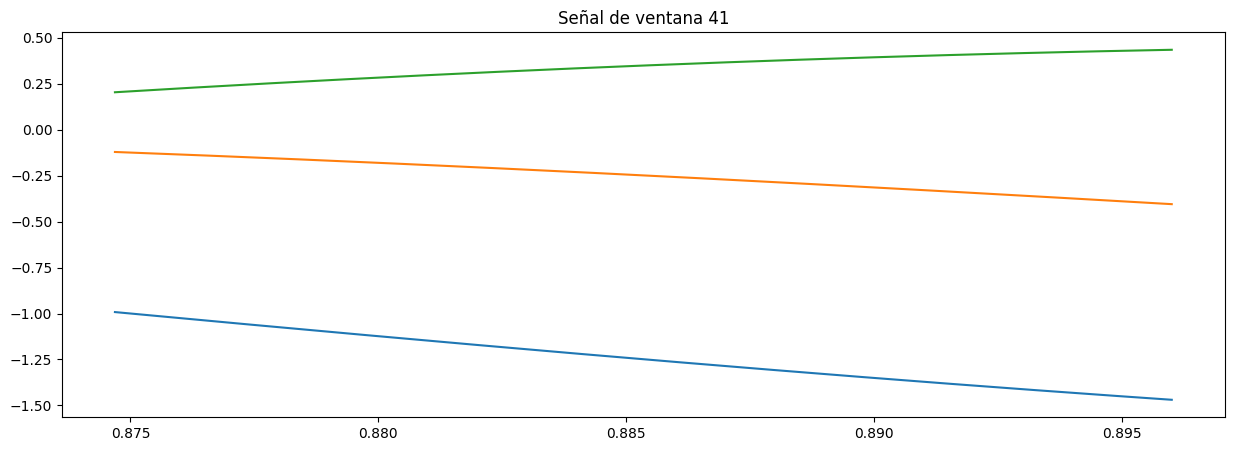

In [25]:
ventana_random=np.random.randint(0,num_ventanas-1)
music_random=MUSIC(this_ws,x_v_array[ventana_random],angles,n_ruidoso)
plt.title(f'Señal de ventana {ventana_random}')
plt.plot(t_v_array[ventana_random],x_v_array[ventana_random][0])
plt.plot(t_v_array[ventana_random],x_v_array[ventana_random][1])
plt.plot(t_v_array[ventana_random],x_v_array[ventana_random][2])
plt.show()
music_plot(angles,music_random,this_ws,titulo=f'Music para ventana {ventana_random}')

In [26]:
x_v_array[ventana_random].shape

(3, 1024)

## Detectar DOAS partiendo cada intervalo como si fuera una ventana  con HANN


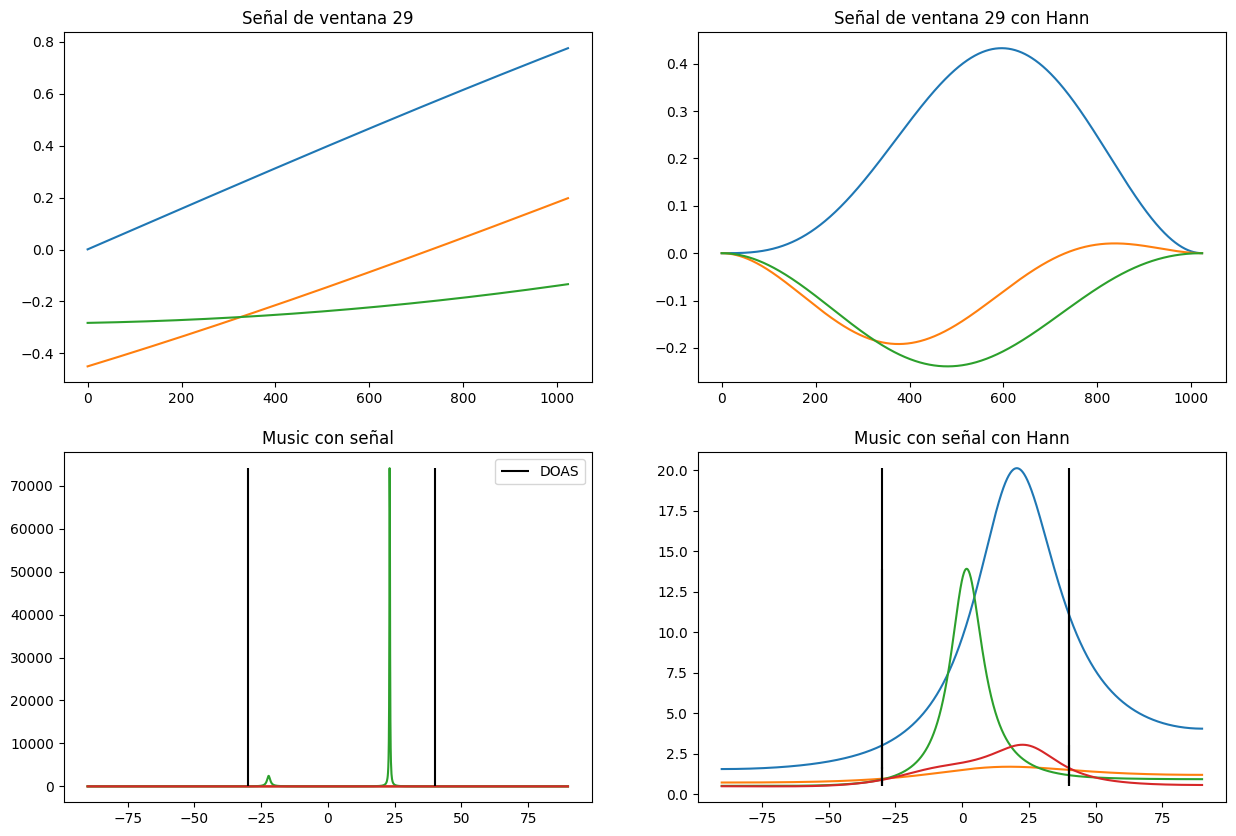

In [27]:
ventana_random=np.random.randint(0,num_ventanas-1)

hann=lambda x:0.5*(1-np.cos(2*pi*np.linspace(0,1,x)))
hann_array=hann(x_v_array[0].shape[1])



fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(15,10))
ax[0,0].set_title(f'Señal de ventana {ventana_random}')
ax[0,0].plot((x_v_array[0])[0])
ax[0,0].plot((x_v_array[0])[1])
ax[0,0].plot((x_v_array[0])[2])


ax[0,1].set_title(f'Señal de ventana {ventana_random} con Hann')
ax[0,1].plot((x_v_array[0]*hann_array)[0])
ax[0,1].plot((x_v_array[0]*hann_array)[1])
ax[0,1].plot((x_v_array[0]*hann_array)[2])


music_random=MUSIC(this_ws,x_v_array[ventana_random],angles,n_ruidoso)

ax[1,0].set_title('Music con señal')
for i in range(music_random.shape[0]):
    ax[1,0].plot(angles,music_random[i])
ax[1,0].vlines(DOAS,music_random.min(),music_random.max(),colors='k',label='DOAS')
ax[1,0].legend()

music_random_hann=MUSIC(this_ws,x_v_array[ventana_random]*hann_array,angles,n_ruidoso)

ax[1,1].set_title('Music con señal con Hann')

for i in range(music_random.shape[0]):
    ax[1,1].plot(angles,music_random_hann[i])
    ax[1,1].vlines(DOAS,music_random_hann[i].min(),music_random_hann[i].max(),colors='k')
plt.show()

Agarramos las dos mayores intensidades de MUSIC, vemos sus ángulos (para con y sin Hann) y hacemos un histograma 

# Leyendo archivo de AIRA

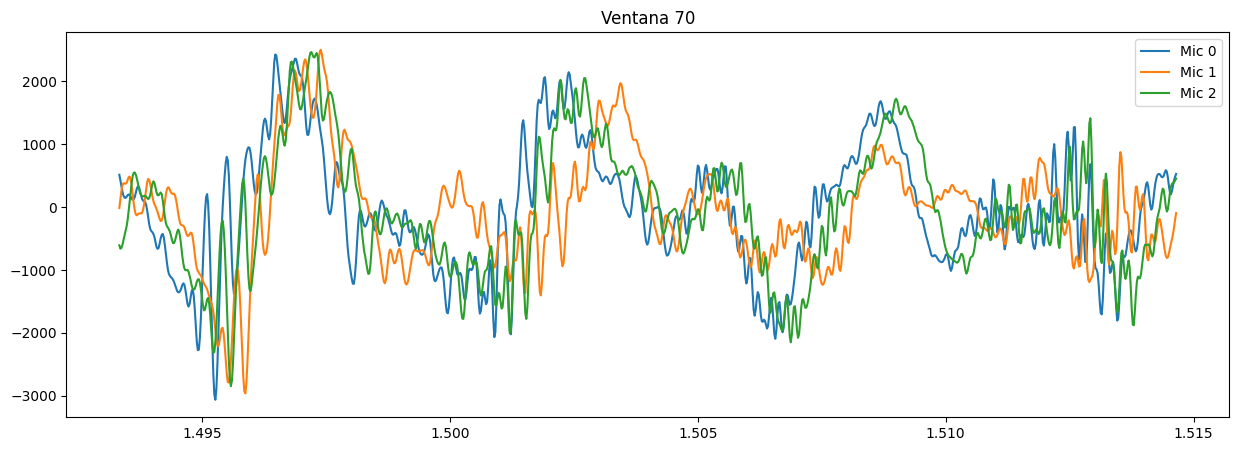

In [28]:


def leer_señal_array(path):
    wav_object=wave.open(f'{path}','rb')
    fr=wav_object.getframerate() # 48000 Hz
    ns=wav_object.getnframes() # 1539072


    signal_wave=wav_object.readframes(ns)
    signal_array=np.frombuffer(signal_wave,dtype=np.int16)
    
    return signal_array

wav_object=wave.open('../Programas PDA/6. AIRA/clean-2source/wav_mic1.wav','rb')
fr_AIRA=wav_object.getframerate() # 48000 Hz
ns_AIRA=wav_object.getnframes() # 1539072
T_AIRA=ns_AIRA/fr_AIRA # 32s
nchannels_AIRA=wav_object.getnchannels() # 1

ventana_estudio=70 # Arriba de esta ventana empieza a agarrar ruido real

mic_array_AIRA1=leer_señal_array('../Programas PDA/6. AIRA/clean-2source/wav_mic1.wav')[(1024*ventana_estudio):1024*(ventana_estudio+1)]
mic_array_AIRA2=leer_señal_array('../Programas PDA/6. AIRA/clean-2source/wav_mic2.wav')[(1024*ventana_estudio):1024*(ventana_estudio+1)]
mic_array_AIRA3=leer_señal_array('../Programas PDA/6. AIRA/clean-2source/wav_mic3.wav')[(1024*ventana_estudio):1024*(ventana_estudio+1)]

n_ventanas_AIRA=mic_array_AIRA1.shape[0]//n_ventana

lista_señales_AIRA=[mic_array_AIRA1,mic_array_AIRA2,mic_array_AIRA3]

time_AIRA=np.linspace(0,T_AIRA,num=ns_AIRA)[(1024*ventana_estudio):1024*(ventana_estudio+1)]


# traces=[go.Scatter(x=time_AIRA,y=li[:1024],mode='lines',name=f's_{i}') for i,li in enumerate(lista_señales_AIRA)]
# fig=go.Figure()
# [fig.add_trace(trace) for trace in traces]
# fig.update_layout(
#     title='Primera ventana para las tres señales',xaxis_title='x', yaxis_title='F(x)',
#     height=500, width=900, template='plotly_dark'
# )
# fig.show(renderer='png')

plt.title(f'Ventana {ventana_estudio}')
for i,li in enumerate(lista_señales_AIRA):
    plt.plot(time_AIRA,li,label=f'Mic {i}')
plt.legend()
plt.show()

Vemos las señales originales las transformamos con la A y esperamos ver algo parecido a la de los micrófonos 

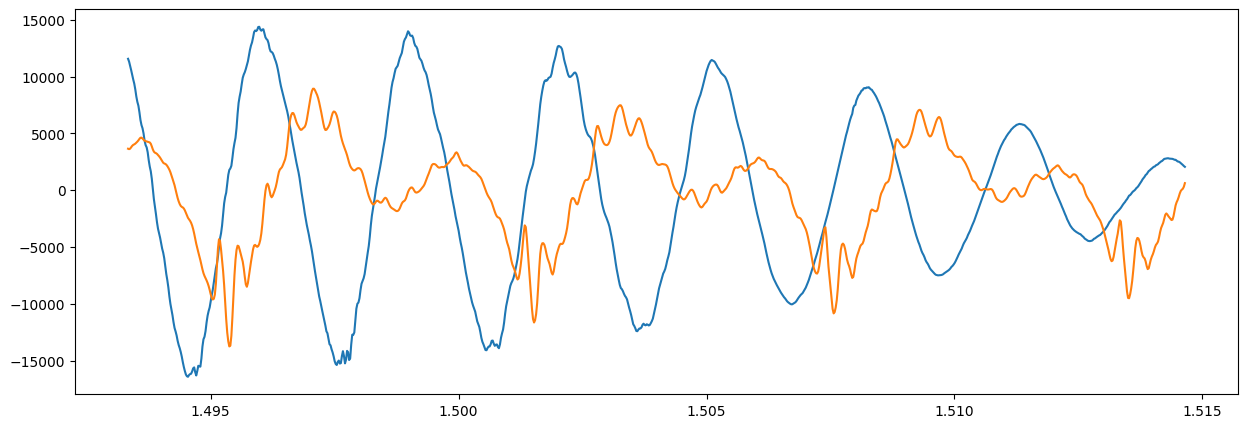

In [29]:
s1_AIRA=leer_señal_array('../Programas PDA/6. AIRA/clean-2source/pristine_channel1.wav')[(1024*ventana_estudio):1024*(ventana_estudio+1)]
s2_AIRA=leer_señal_array('../Programas PDA/6. AIRA/clean-2source/pristine_channel2.wav')[(1024*ventana_estudio):1024*(ventana_estudio+1)]


dm_AIRA=0.18 # Separación de micrófonos en metros
DOAS_AIRA=[-30,90]
N_mic_AIRA=3
s1_AIRA.shape,s2_AIRA.shape
freq_array_AIRA=arreglo_frecuencias(freq_sampleo=fr_AIRA,n_ventana=1024)
s_vec_AIRA=np.c_[s1_AIRA,s2_AIRA]

for i,si in enumerate(s_vec_AIRA.T):
    plt.plot(time_AIRA,si)

In [30]:
A_AIRA=A_completa(DOAS_AIRA,freq_array_AIRA)
s_hat_vec_AIRA=fft.fft(s_vec_AIRA,axis=0)
x_mics_AIRA_señal=np.zeros((N_mic_AIRA,len(freq_array_AIRA)))+0j
for i in range(A_AIRA.shape[0]):
    x_mics_AIRA_señal[:,i]=A_AIRA[i,:,:]@s_hat_vec_AIRA[i,:]
x_mics_AIRA_señal=fft.ifft(x_mics_AIRA_señal,axis=1).real

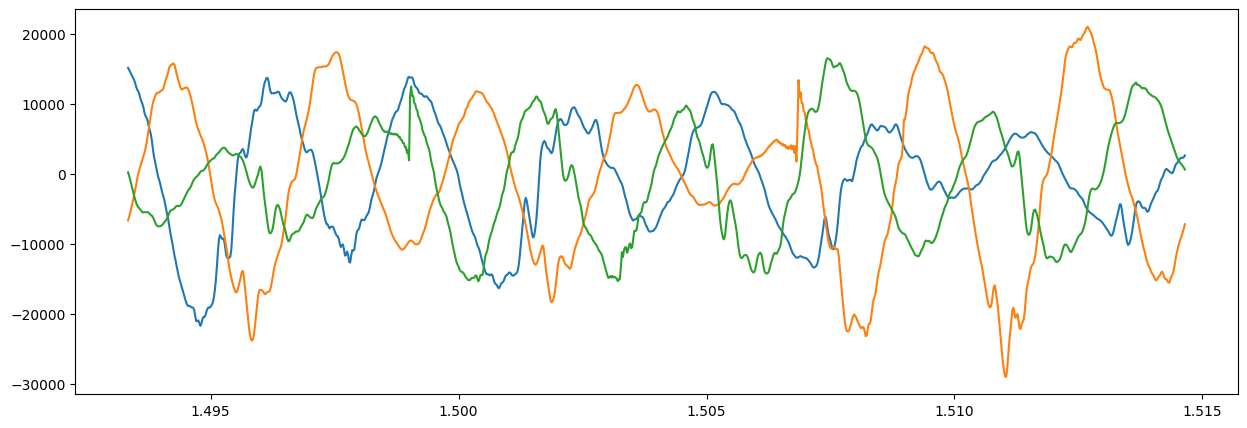

In [31]:
plt.plot(time_AIRA,x_mics_AIRA_señal[0],label='matriz')
plt.plot(time_AIRA,x_mics_AIRA_señal[1],label='matriz')
plt.plot(time_AIRA,x_mics_AIRA_señal[2],label='matriz')


la diferencia con las señales de los micrófonos se debe a el ruido y reverb?

## MUSIC con señal real

In [35]:
this_ws_AIRA=[2,4,6,8] # Lista de frecuencias para buscar el delay. 
x_mics_AIRA=np.array(lista_señales_AIRA)

angles_AIRA=np.arange(-90,90,0.1) # Los ángulos para buscar ortogonalidad
music_spectrum_AIRA=MUSIC(this_ws_AIRA,x_mics_AIRA,angles_AIRA,n_ruidoso)

music_plot(angles_AIRA,music_spectrum_AIRA,this_ws_AIRA)

In [37]:
x_mics_AIRA.shape

(3, 1024)

# Usando la estimación de la matriz X

La matriz $X$ se está calculando paso a paso pero se puede estimar con los pasos anteriores a tavés de ![est](cov.png)